In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
import os
import sys
import random
import warnings

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

import tensorflow as tf

import tensorflow as tf
import cv2
import numpy
import gc
import keras

import matplotlib.pyplot as plt

import tensorflow as tf
import math

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math
tfkc = tfk.callbacks

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Resizing
import tensorflow as tf

def unet_v2(input_size=(538, 701, 3), resize_to=(256, 256)):
    """
    U-Net modell változó szűrőméretekkel.
    """
    inputs = Input(input_size)
    resized_inputs = Resizing(*resize_to)(inputs)

    # Encoder rész
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(resized_inputs)
    conv1 = Conv2D(16, (5, 5), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (7, 7), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (5, 5), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (7, 7), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Middle rész
    conv5 = Conv2D(256, (5, 5), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (7, 7), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder rész
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(128, (7, 7), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (5, 5), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(64, (5, 5), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(2, (1, 1), activation="softmax", padding="same")(conv9)
    resized_outputs = Resizing(input_size[0], input_size[1])(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=resized_outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Modell összeállítása
model = unet_v2()

# Modell összefoglaló
# model_v2.summary()



In [ ]:
import glob

def data_generator_multiple_files(image_pattern, mask_pattern, batch_size):
    """
    Generátor több batch fájlból történő betöltéshez.

    Args:
        image_pattern (str): A képfájlok mintája (pl. 'train_images_batch_*.npy').
        mask_pattern (str): A maszkfájlok mintája (pl. 'train_masks_batch_*.npy').
        batch_size (int): A batch méret.

    Yields:
        tuple: (képek batch, maszkok batch)
    """
    # Batch fájlok betöltése sorrendben
    image_files = sorted(glob.glob(image_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))
    mask_files = sorted(glob.glob(mask_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))

    if len(image_files) != len(mask_files):
        raise ValueError("A képfájlok és maszkfájlok száma nem egyezik meg.")

    while True:  # Végtelen generátor
        for image_file, mask_file in zip(image_files, mask_files):
            # Fájlok betöltése
            images = np.load(image_file, allow_pickle=False)
            masks = np.load(mask_file, allow_pickle=False)

            # Batch-ekre bontás
            for i in range(0, len(images), batch_size):
                image_batch = images[i:i + batch_size]
                mask_batch = masks[i:i + batch_size]
                yield image_batch, mask_batch


In [ ]:
# Adatfájlok mintázata
train_images_pattern = "/content/drive/MyDrive/szakdoga/train_images_batch_*.npy"
train_masks_pattern = "/content/drive/MyDrive/szakdoga/train_masks_batch_*.npy"
test_images_pattern = "/content/drive/MyDrive/szakdoga/test_images_batch_*.npy"
test_masks_pattern = "/content/drive/MyDrive/szakdoga/test_masks_batch_*.npy"

# Adatgenerátorok inicializálása
train_gen = data_generator_multiple_files(train_images_pattern, train_masks_pattern, batch_size=16)
test_gen = data_generator_multiple_files(test_images_pattern, test_masks_pattern, batch_size=16)

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/szakdoga/modellek/valtozo_szuroszam.keras",  # Ez határozza meg az elérési utat és fájlnevet
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min"
)

from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback inicializálása
early_stopping = EarlyStopping(
    monitor='val_loss',  # Mit figyeljünk (pl. validation loss)
    patience=3,          # Hány epoch után álljon meg, ha nincs javulás
    restore_best_weights=True  # Állítsa vissza a legjobb súlyokat
)



# Train és validation adatok méretének statikus meghatározása
train_size = 3264  # Az összes train adat száma
val_size = 800     # Az összes validation adat száma

# Train és validation adatok méretének meghatározása
#train_size = sum(len(np.load(f, allow_pickle=False)) for f in glob.glob(train_images_pattern))
#val_size = sum(len(np.load(f, allow_pickle=False)) for f in glob.glob(test_images_pattern))


In [ ]:
import numpy as np
import glob

# Ellenőrizz egy fájlt
test_file = "/content/drive/MyDrive/szakdoga/train_masks_batch_0.npy"
data = np.load(test_file, allow_pickle=False)
print(data.shape)


(25, 538, 701, 2)


In [ ]:
# Tanítás
history = model.fit(
    train_gen,
    steps_per_epoch=train_size // 32,  # Batch-ek száma epochonként
    validation_data=test_gen,
    validation_steps=val_size // 32,  # Validation batch-ek száma
    epochs=10,  # Maximum epochok száma
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.8124 - loss: 0.9156 
Epoch 1: val_loss improved from inf to 0.11058, saving model to /content/drive/MyDrive/szakdoga/modellek/valtozo_szuroszam.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 2519s 25s/step - accuracy: 0.8132 - loss: 0.9104 - val_accuracy: 0.9588 - val_loss: 0.1106
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.9719 - loss: 0.0818 
Epoch 2: val_loss improved from 0.11058 to 0.04747, saving model to /content/drive/MyDrive/szakdoga/modellek/valtozo_szuroszam.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 2532s 25s/step - accuracy: 0.9720 - loss: 0.0816 - val_accuracy: 0.9814 - val_loss: 0.0475
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.9862 - loss: 0.0365 
Epoch 3: val_loss improved from 0.04747 to 0.02355, saving model to /content/drive/MyDrive/szakdoga/modellek/valtozo_szuroszam.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 2555s 25s/step - accuracy: 0.9862 - loss: 0.0365 - val_accuracy: 0.9907 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


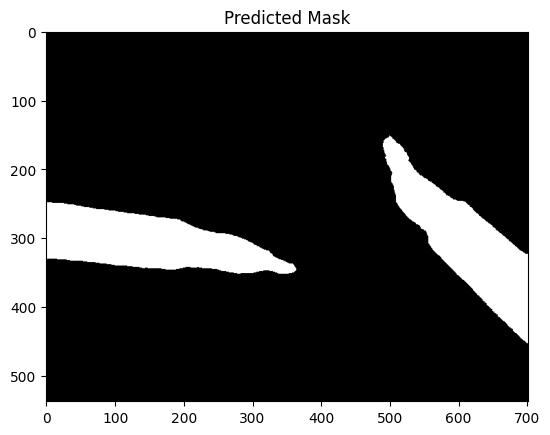

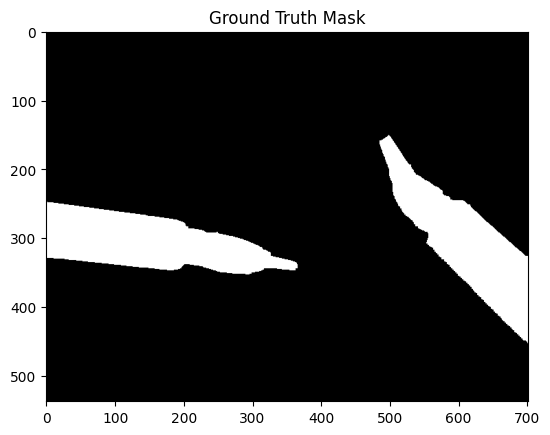

IoU Score: 0.9596108688359611
Dice Coefficient: 0.9793892084360449


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import random
import glob

# A legjobb modell betöltése
best_model = load_model('/content/drive/MyDrive/szakdoga/modellek/valtozo_szuroszam.keras')

# Batch fájlok mintája
test_images_pattern = "/content/drive/MyDrive/szakdoga/test_images_batch_*.npy"
test_masks_pattern = "/content/drive/MyDrive/szakdoga/test_masks_batch_*.npy"

# Összes batch fájl száma
test_image_files = sorted(glob.glob(test_images_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))
test_mask_files = sorted(glob.glob(test_masks_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))

total_batches = len(test_image_files)

# Véletlenszerű batch fájl kiválasztása
random_batch_index = random.randint(0, total_batches - 1)
random_image_file = f"/content/drive/MyDrive/szakdoga/test_images_batch_{random_batch_index}.npy"
random_mask_file = f"/content/drive/MyDrive/szakdoga/test_masks_batch_{random_batch_index}.npy"

# Batch fájlok betöltése
test_images = np.load(random_image_file)
test_masks = np.load(random_mask_file)

# Véletlenszerű kép kiválasztása a batch-ből
random_image_index = random.randint(0, len(test_images) - 1)
selected_image = test_images[random_image_index:random_image_index + 1]  # Batch formátumban a modellhez
selected_mask = test_masks[random_image_index]  # Eredeti maszk

# Előrejelzés az adott képre
predictions = best_model.predict(selected_image)  # Egyetlen mintát küldünk a modellnek
predicted_mask = np.argmax(predictions[0], axis=-1)  # Argmax az osztályokra

# Megjelenítés az előrejelzett maszkról
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

# A valós maszk egycsatornás formára konvertálása
ground_truth_mask = np.argmax(selected_mask, axis=-1)

# Megjelenítés a valósághű maszkról
plt.figure()
plt.imshow(ground_truth_mask, cmap='gray')
plt.title('Ground Truth Mask')

plt.show()

# Metrikák számítása
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    return np.sum(intersection) / np.sum(union)

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

print("IoU Score:", iou_score(ground_truth_mask, predicted_mask))
print("Dice Coefficient:", dice_coefficient(ground_truth_mask, predicted_mask))
